In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import ydata_profiling
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
# これで確実に警告を消せる
import warnings
warnings.filterwarnings('ignore')

In [55]:
df = pd.read_csv("/Users/yoshitakanishikawa/Downloads/assignment-main/Trainee/time-series-prediction/stock_price.csv")


In [ ]:
def convert_volume_with_apply(volume_str):
    """
    出来高の文字列を数値に変換する関数
    """
    if pd.isna(volume_str):
        return np.nan

    volume_str = str(volume_str)

    # 右端の文字で単位を判定
    last_char = volume_str[-1]

    if last_char == 'M':  # ミリオン
        return float(volume_str[:-1]) * 1_000_000
    elif last_char == 'B':  # ビリオン
        return float(volume_str[:-1]) * 1_000_000_000
    elif last_char == 'K':  # キロ
        return float(volume_str[:-1]) * 1_000
    else:  # 単位なし
        return float(volume_str)

【データ理解　EDA】

In [61]:
df.describe()

,日付け,終値,始値,高値,安値,出来高,変化率 %
count,9202,9202.000000,9202.000000,9202.000000,9202.000000,9.202000e+03,9202.000000
mean,2005-10-21 08:44:04.642468992,92.180961,92.256183,93.176451,91.330146,1.726677e+08,0.000175
min,1987-02-12 00:00:00,33.000000,33.000000,33.200000,32.200000,9.340000e+06,-0.147400
25%,1996-06-06 06:00:00,52.000000,52.100000,52.800000,51.500000,8.073000e+07,-0.009400
50%,2005-10-11 12:00:00,85.100000,85.100000,86.050000,84.200000,1.540150e+08,0.000000
75%,2015-03-04 18:00:00,110.800000,110.800000,111.900000,109.275000,2.305225e+08,0.009000
max,2024-08-01 00:00:00,305.900000,309.800000,311.800000,303.900000,1.280000e+09,0.162500
std,NaN,50.452228,50.598215,51.049837,50.087405,1.251280e+08,0.018767


In [83]:
ydata_profiling.ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00, 379.34it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

【前処理と特徴量エンジニアリング】

In [ ]:
#### --> 出来高列の前処理
df["出来高"].str[-1].unique()
df['出来高'] = df['出来高'].apply(convert_volume_with_apply)

#### --> 変化率列の前処理
df["変化率 %"] = df["変化率 %"].str.replace("%", "").astype(float) / 100

#### --> 日付け列の前処理
#日付け列をdatetime型に変換
df["日付け"] = pd.to_datetime(df["日付け"])
print(df.dtypes)

#日付を並び替え
df = df.sort_values("日付け", ascending=True).reset_index(drop=True)


In [ ]:
#### --> 日付け列の内容確認(歯抜け)
start_date = df["日付け"].min()
end_date = df["日付け"].max()
sample_dates = pd.date_range(start=start_date, end=end_date)

df_dates_set = set(df["日付け"])

# sample_datesにあるが、df_dates_setにはない日付をリスト化
missing_dates = [date for date in sample_dates if date not in df_dates_set]

# 結果を表示
if len(missing_dates) > 0:
    print("以下の日付が欠損しています:")
    for date in missing_dates:
        print(date)
else:
    print("欠損している日付はありません。")

print(f"\n欠損の日付count : {len(missing_dates)}")

以下の日付が欠損しています:
1987-02-14 00:00:00
1987-02-15 00:00:00
1987-02-21 00:00:00
1987-02-22 00:00:00
1987-02-28 00:00:00
1987-03-01 00:00:00
1987-03-07 00:00:00
1987-03-08 00:00:00
1987-03-14 00:00:00
1987-03-15 00:00:00
1987-03-21 00:00:00
1987-03-22 00:00:00
1987-03-28 00:00:00
1987-03-29 00:00:00
1987-04-04 00:00:00
1987-04-05 00:00:00
1987-04-11 00:00:00
1987-04-12 00:00:00
1987-04-18 00:00:00
1987-04-19 00:00:00
1987-04-25 00:00:00
1987-04-26 00:00:00
1987-04-29 00:00:00
1987-05-02 00:00:00
1987-05-03 00:00:00
1987-05-04 00:00:00
1987-05-05 00:00:00
1987-05-09 00:00:00
1987-05-10 00:00:00
1987-05-16 00:00:00
1987-05-17 00:00:00
1987-05-23 00:00:00
1987-05-24 00:00:00
1987-05-30 00:00:00
1987-05-31 00:00:00
1987-06-06 00:00:00
1987-06-07 00:00:00
1987-06-13 00:00:00
1987-06-14 00:00:00
1987-06-20 00:00:00
1987-06-21 00:00:00
1987-06-27 00:00:00
1987-06-28 00:00:00
1987-07-04 00:00:00
1987-07-05 00:00:00
1987-07-11 00:00:00
1987-07-12 00:00:00
1987-07-18 00:00:00
1987-07-19 00:00:00
1987-

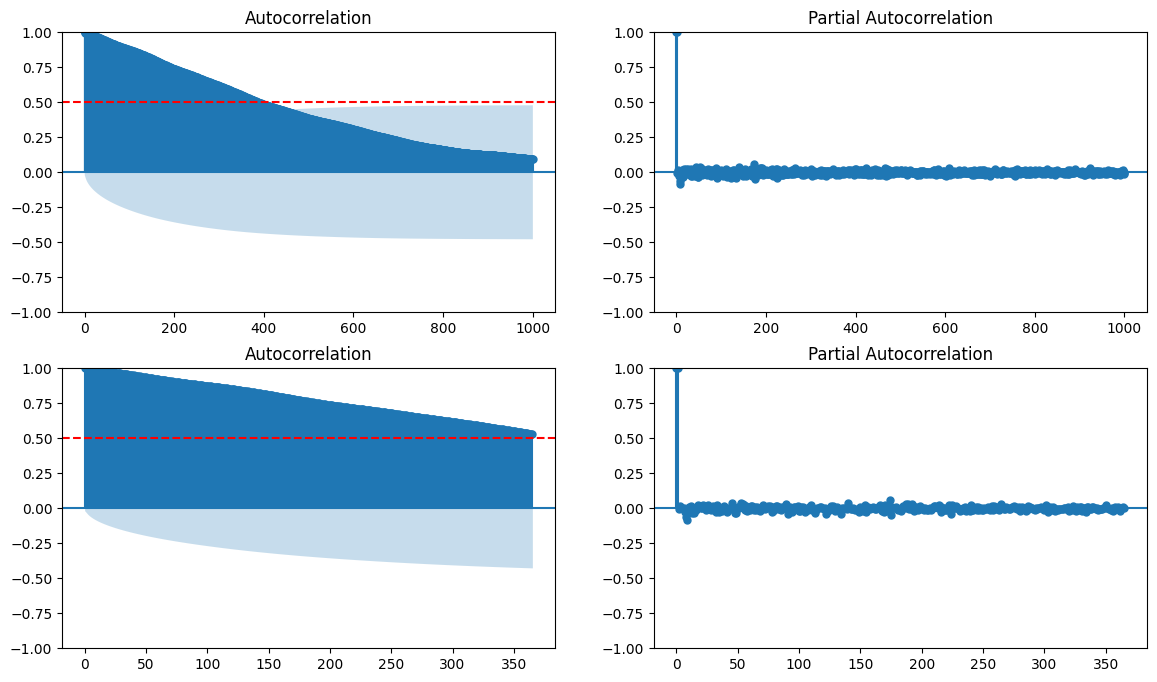

In [63]:
fig, ax = plt.subplots(2, 2, figsize=(14,8))
plot_acf(df["終値"], ax=ax[0, 0], lags=1000)
ax[0,0].axhline(y=0.5, color='red', linestyle='--')

plot_pacf(df["終値"], ax=ax[0, 1], lags=1000)

plot_acf(df["終値"], ax=ax[1, 0], lags=365)
ax[1,0].axhline(y=0.5, color='red', linestyle='--')

plot_pacf(df["終値"], ax=ax[1, 1], lags=365)
plt.show()

In [64]:
m = Prophet()

In [65]:
sampling_term = 30

target = "終値"
sample = df[["日付け",target]]
sample_test = sample.tail(sampling_term)
sample_train = sample.rename(columns={"日付け": "ds", target: "y"}).drop(sample_test.index)
m.fit(sample_train)

23:05:20 - cmdstanpy - INFO - Chain [1] start processing
23:05:26 - cmdstanpy - INFO - Chain [1] done processing


In [66]:
future = sample_test[["日付け"]].rename(columns={"日付け":"ds"})
forecast = m.predict(future)

In [67]:
y_pred = forecast["yhat"]
y_test = sample_test[target]
mape_score = mean_absolute_percentage_error(y_pred,y_test)
print(f"MAPE : {mape_score *100:.3f} %")

MAPE : 5.569 %


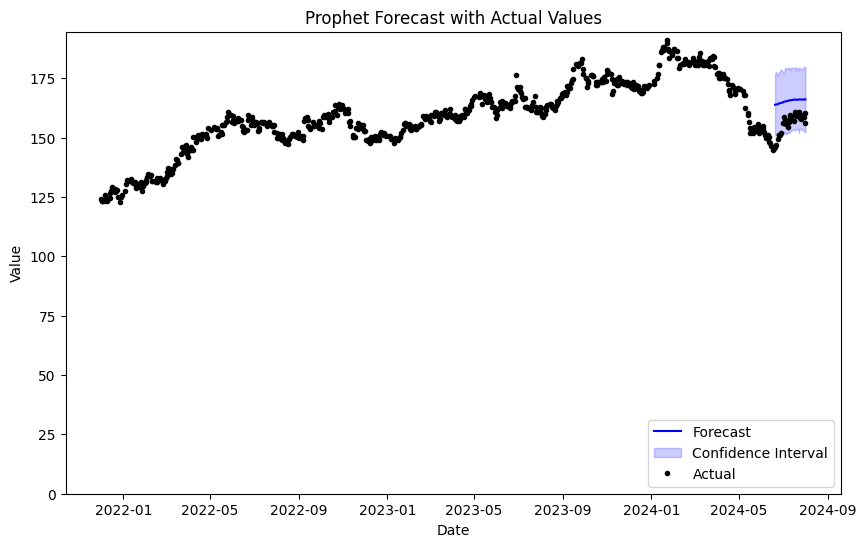

In [ ]:
# グラフを描画するaxオブジェクトを作成
fig, ax = plt.subplots(figsize=(10, 6))

# 1. 予測値をプロット（yhatと信頼区間）
ax.plot(forecast['ds'], forecast['yhat'], color='blue', label='Forecast')
ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.2, label='Confidence Interval')

actual_data = sample.loc[sample['日付け'] >= '2021-12-01']
ax.plot(actual_data['日付け'], actual_data['終値'], 'k.', label='Actual')

ax.set_title('Prophet Forecast with Actual Values')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend(loc='lower right')

ax.set_ylim(0, None)

plt.show()

fig2 = m.plot_components(forecast)

汎化性能の検証

In [94]:
"""
学習期間：過去2年分
汎化性能用にずらす間隔：3ヶ月ごと
予測する未来の期間：30日分
"""
total_rows = len(df)
initial_days = total_rows - sampling_term

df_cv = cross_validation(m, initial=f'{initial_days} days', period='90 days', horizon='30 days')

  0%|          | 0/50 [00:00<?, ?it/s]

01:01:36 - cmdstanpy - INFO - Chain [1] start processing
01:01:39 - cmdstanpy - INFO - Chain [1] done processing
01:01:39 - cmdstanpy - INFO - Chain [1] start processing
01:01:42 - cmdstanpy - INFO - Chain [1] done processing
01:01:43 - cmdstanpy - INFO - Chain [1] start processing
01:01:46 - cmdstanpy - INFO - Chain [1] done processing
01:01:46 - cmdstanpy - INFO - Chain [1] start processing
01:01:49 - cmdstanpy - INFO - Chain [1] done processing
01:01:49 - cmdstanpy - INFO - Chain [1] start processing
01:01:52 - cmdstanpy - INFO - Chain [1] done processing
01:01:53 - cmdstanpy - INFO - Chain [1] start processing
01:01:55 - cmdstanpy - INFO - Chain [1] done processing
01:01:56 - cmdstanpy - INFO - Chain [1] start processing
01:01:59 - cmdstanpy - INFO - Chain [1] done processing
01:01:59 - cmdstanpy - INFO - Chain [1] start processing
01:02:03 - cmdstanpy - INFO - Chain [1] done processing
01:02:03 - cmdstanpy - INFO - Chain [1] start processing
01:02:06 - cmdstanpy - INFO - Chain [1]

In [95]:
# ホライズンごとのMAPE, RMSEなどを計算
df_p = performance_metrics(df_cv, metrics=['mape'])

# 結果の確認
print(df_p)

   horizon      mape
0   3 days  0.143757
1   4 days  0.135454
2   5 days  0.131871
3   6 days  0.136491
4   7 days  0.147452
5   8 days  0.152682
6   9 days  0.152331
7  10 days  0.148878
8  11 days  0.143222
9  12 days  0.139538
10 13 days  0.137704
11 14 days  0.142595
12 15 days  0.147561
13 16 days  0.151675
14 17 days  0.151095
15 18 days  0.142617
16 19 days  0.139178
17 20 days  0.145532
18 21 days  0.160220
19 22 days  0.168906
20 23 days  0.164582
21 24 days  0.154873
22 25 days  0.145530
23 26 days  0.142129
24 27 days  0.146539
25 28 days  0.157149
26 29 days  0.163150
27 30 days  0.163714
